## SHAP 범주형 변수를 Embedding을 해서 진행해도, SHAP는 특이하게 계산이 안되는 것 같다.

In [769]:
import torch, torchvision
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F
import numpy as np
import shap
import pandas as pd
sys.path.append("/home/advice/Python/Pycharm/SR/PersonalProject/Custom/PreProcessingUtils/")
from TabularDataPipeline import *

In [770]:
data = pd.read_csv("./../../../Data/kdd/uci/uci_creditcard-train-0.2-0.0.csv")
in_var = ["LIMIT_BAL", "SEX", "EDUCATION", "MARRIAGE", "AGE", "PAY_0", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6",
          "BILL_AMT1", "BILL_AMT2", "BILL_AMT3", "BILL_AMT4", "BILL_AMT5", "BILL_AMT6",
          "PAY_AMT1", "PAY_AMT2", "PAY_AMT3", "PAY_AMT4", "PAY_AMT5", "PAY_AMT6"]
target_var = ['default payment next month']
fac_var = [ 'SEX','EDUCATION','MARRIAGE',]
num_var = [i for i in in_var if not i in fac_var]
train = data[data.sep_idx ==1 ]
valid = data[data.sep_idx ==0 ]
test = pd.read_csv("./../../../Data/kdd/uci/uci_creditcard-test-0.2-0.0.csv")

In [771]:
pipe = TabularPipeline(in_var, num_var, target_var)
info = {
#     "Outlier" : {"method" : "IQR", "multiple_outlier_n" :4 , "var": num_var} , 
    "NumericImpute" : {"method" : "mean", "var" : num_var},
    "FactorImpute" : {"method" : "most_frequent", "var" : fac_var},}
pipe.insert(info)
pipe.Steps()
train = pipe.fit_transform(train)
test = pipe.transform(test)


          Build The Pipeline          

Fit Missing Data / Method : mean
var : ['LIMIT_BAL', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
Fit Missing Data / Method : most_frequent
var : ['SEX', 'EDUCATION', 'MARRIAGE']


In [772]:
pipe = TabularPipeline(in_var, num_var, target_var)
info = {
#     "Outlier" : {"method" : "IQR", "multiple_outlier_n" :4 , "var": num_var} , 
#     "NumericImpute" : {"method" : "mean", "var" : num_var},
#     "FactorImpute" : {"method" : "most_frequent", "var" : fac_var},
    "Numeric" : {"method" : "sklearn:minmax", "var" : num_var , 
                 "method_option" : {"feature_range" : (-1.0,1.0)}},
    "Category" : {"method" : "labelencoding"} , 
       }
pipe.insert(info)
pipe.Steps()

{'method': 'sklearn:minmax', 'var': ['LIMIT_BAL', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'], 'method_option': {'feature_range': (-1.0, 1.0)}}

          Build The Pipeline          



In [773]:
from python_utils import make_dirs
method = True
ResultPath = "./Result/Torch_XAI"
folder_names = make_dirs(ResultPath , local_path=[])
if method :
    pipe.fit(train[in_var])
else :
    pipe.fit(train)
save_pipe_path = f"{ResultPath}/pipe.pkl"
ReusePipe = BADSPipeLine(save_pipe_path)
ReusePipe.save(pipe.PIPE)
ReusePipe.load()

Fit Numeric Data Method : ('sklearn:minmax', "{'feature_range': (-1.0, 1.0)}")
var : ['LIMIT_BAL', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
Fit Categorical Data / method : labelencoding
var : ['SEX', 'EDUCATION', 'MARRIAGE']

          Fit The Pipeline!          

Save Pipeline path : ./Result/Torch_XAI/pipe.pkl
Load Pipeline


In [774]:
method = True
if method :
#     train_xai = ReusePipe.transform(train)
#     train_xai = train_xai.values
    train , train_y = train[in_var] , train[target_var[0]].values.reshape(-1,1)
    valid , valid_y = valid[in_var] , valid[target_var[0]].values.reshape(-1,1)
    test , test_y   = test[in_var] , test[target_var[0]].values.reshape(-1,1)
    train_x = train.values
    valid_x = valid.values
    test_x = test.values
else :
    train = ReusePipe.transform(train)
    valid = ReusePipe.transform(valid)
    test = ReusePipe.transform(test)
    train_x ,train_y , _ = ReusePipe.split(train, numpy= True)
    valid_x , valid_y , _ = ReusePipe.split(valid, numpy= True)
    test_x , test_y , _ = ReusePipe.split(test, numpy= True)

In [800]:
from torch.utils.data import Dataset, DataLoader, random_split
class TabularDataset(Dataset) :
    def __init__(self, X , y , pipe) :
        self.X = X
        self.y = y
        self.pipe = pipe
    def __len__(self) :
        return len(self.X)
    def __getitem__(self,idx) :
        if isinstance(idx, torch.Tensor):
            idx = idx.tolist()
#         transX = np.squeeze(self.pipe.transform(self.X.iloc[[idx],:]).values.astype(np.float32))
        transX = self.X.iloc[idx].values.astype(np.float32)
        return [transX,self.y[idx]]

In [813]:
train_y

array([[1.],
       [1.],
       [0.],
       ...,
       [0.],
       [1.],
       [1.]])

In [801]:
trans_trainX = ReusePipe.transform(train)
trans_testX = ReusePipe.transform(test)

In [802]:
class Net(nn.Module) :
    def __init__(self) :
        super(Net,self).__init__()
        
        embs = []
        for idx, (key , value) in enumerate(information["cat_info"].items()) :
            emb = torch.nn.Embedding(num_embeddings=max(value.values())+1,
                                     embedding_dim=3,padding_idx=1)
            embs.append(emb)
        self.emb_layers = nn.ModuleList(embs)
        self.fc = nn.Sequential(
            nn.Linear(29,20),
            nn.LeakyReLU(),
            nn.Linear(20,10),
            nn.LeakyReLU(),
            nn.Linear(10,1)
        )
        
    def forward(self,x) :
#         x = pd.DataFrame(x.detach().numpy(),columns=in_var)
#         x = ReusePipe.transform(x).values.astype(np.float32)
#         x = torch.from_numpy(x).float().to(device)
        x = self.embedding(x)
        x = self.fc(x)
        return x
    
    def embedding(self, x) :
        result = []
        for idx, (key , value) in enumerate(information["cat_info"].items()) :
            if idx == 0 :
                a = torch.narrow(x,dim=1,start=0, length=int(key))
                result.append(a)
            a = torch.narrow(x,dim=1,start=int(key), length=1)
            if len(value) == 2 :
                y_onehot = torch.FloatTensor(a.size()[0], len(value)+1)
                y_onehot.zero_()
                a = y_onehot.scatter_(1, a.long(), 1)
            else :
#                 emb = torch.nn.Embedding(num_embeddings=len(value),
#                                          embedding_dim=2)
#                 a = emb(a.long().squeeze(dim=1))
                try :
                    a = self.emb_layers[idx](a.long().squeeze(dim=1))
                except Exception as e :
                    raise
            result.append(a)
        transX = torch.cat(result,dim=1)
        return transX

In [803]:
trainset = TabularDataset(trans_trainX , train_y, ReusePipe)
testset = TabularDataset(trans_testX , test_y, ReusePipe)
# trainset = TabularDataset(train , train_y, ReusePipe)
# testset = TabularDataset(test , test_y, ReusePipe)

In [804]:
# train_size = int(0.8 * len(dataset))
# test_size = len(dataset) - train_size
# trainset, testset = random_split(dataset, [train_size, test_size])


In [806]:
trainloader = DataLoader(trainset, batch_size=100, shuffle=True,num_workers=20)

In [812]:
dataiter = iter(trainloader)
test_in , test_y = dataiter.next()
test_in , test_y

(tensor([[-0.9192, -0.8519, -0.6029,  ...,  3.0000,  3.0000,  1.0000],
         [-0.9798, -0.0370, -0.4000,  ...,  3.0000,  4.0000,  2.0000],
         [-0.8990, -0.8519, -0.2000,  ...,  2.0000,  3.0000,  2.0000],
         ...,
         [-0.9192, -0.9259, -0.6029,  ...,  4.0000,  3.0000,  1.0000],
         [-0.8990, -0.8148, -0.8000,  ...,  2.0000,  3.0000,  1.0000],
         [-0.6162,  0.0370, -0.6000,  ...,  2.0000,  2.0000,  2.0000]]),
 tensor([[1.],
         [0.],
         [1.],
         [0.],
         [0.],
         [1.],
         [1.],
         [1.],
         [0.],
         [1.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [1.],
         [0.],
         [1.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
   

In [808]:
# dataiter = iter(trainloader)
# for _ in range(2) :
#     test_in , test_y = dataiter.next()
#     information = ReusePipe.return_trans_info()
#     result = []
#     for idx, (key , value) in enumerate(information["cat_info"].items()) :
#         if idx == 0 :
#             num = torch.narrow(test_in,dim=1,start=0, length=int(key))
#             result.append(num)
#         a = torch.narrow(test_in,dim=1,start=int(key), length=1)
#         if len(value) == 2 :
#             y_onehot = torch.FloatTensor(a.size()[0], len(value)+1)
#             y_onehot.zero_()
#             aa = y_onehot.scatter_(1, a.long(), 1)
#         else :
#             emb = torch.nn.Embedding(num_embeddings=max(value.values())+1,
#                                      embedding_dim=3)
#             try :
#                 aa = emb(a.long().squeeze(dim=1))
#             except Exception as e :
#                 print(e)
#                 raise Exception(e)
#             #.squeeze(dim=1)
#         result.append(aa)
#     transX = torch.cat(result,dim=1)
#     print(transX.size())

In [809]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device= "cpu"

In [810]:
model = Net() # .device(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), weight_decay=0.0001)
n_epochs = 100
# Train the net
loss_per_iter = []
loss_per_batch = []
for epoch in range(n_epochs):
    print(f"Epoch : {epoch}", end="\r")
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(trainloader):
        inputs = inputs.to("cpu")
#         labels = labels.type(torch.LongTensor).to(device)
        # Zero the parameter gradients
        
        # Forward + backward + optimize
        outputs = model(inputs.float())
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Save loss to plot
        running_loss += loss.item()
        loss_per_iter.append(loss.item())
        print(f"epoch: {epoch} , iter: {i} : loss: {loss.item():.3f}", end="\r")
    loss_per_batch.append(running_loss / (i + 1))
    running_loss = 0.0

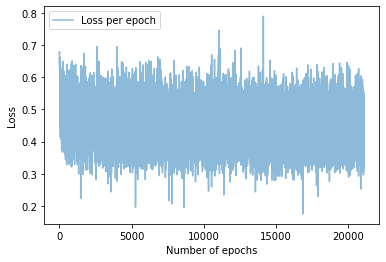

In [811]:
# Comparing training to test
dataiter = iter(testloader)
inputs, labels = dataiter.next()
inputs = inputs.to(device)
labels = labels.type(torch.LongTensor).to(device)
outputs = model(inputs)
# print("Training:", loss_per_batch[-1])
# print("Test", criterion(outputs, labels).detach().cpu().numpy())
import matplotlib.pyplot as plt
# Plot training loss curve
plt.plot(np.arange(len(loss_per_iter)), loss_per_iter, "-", alpha=0.5, label="Loss per epoch")
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [656]:
# test_value = ReusePipe.transform(test[in_var]).head(100).values.astype(np.float32)
# torch_data = torch.from_numpy(test_value).to("cpu").float()

In [786]:
testloader = DataLoader(testset, batch_size=100, shuffle=False, num_workers = 10)
batch = next(iter(testloader))
test_value , _ = batch

In [787]:
test_value

tensor([[-0.6566, -0.1852, -0.8000,  ...,  4.0000,  2.0000,  1.0000],
        [-0.8788, -0.6296, -0.6029,  ...,  3.0000,  2.0000,  2.0000],
        [-0.9192, -0.9630, -0.6000,  ...,  3.0000,  3.0000,  2.0000],
        ...,
        [-0.8990, -0.9259, -0.6000,  ...,  2.0000,  3.0000,  2.0000],
        [-0.9192, -0.9259, -0.6000,  ...,  2.0000,  3.0000,  2.0000],
        [-0.8586, -0.8889, -0.6000,  ...,  3.0000,  3.0000,  2.0000]])

In [788]:
explainer_shap = shap.DeepExplainer(model, test_value)

In [789]:
## 매우 느림
shap_values = explainer_shap.shap_values(test_value,output_rank_order ="max",ranked_outputs =20)

In [790]:
shap.initjs()

In [791]:
# shap_values[0]

shap_values

array([[-4.49728468e-05,  3.54052745e-02, -3.10841743e-02, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-4.43755154e-04, -3.11776400e-02, -5.00180293e-04, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 7.03459023e-04, -7.05481917e-02,  3.84350278e-04, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [-5.37102693e-04, -7.30080381e-02, -2.86858558e-04, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-7.25464430e-04, -7.31447935e-02, -3.61444690e-04, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 3.24375374e-04, -6.14465475e-02,  2.89322896e-04, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [792]:
shap.force_plot(explainer_shap.expected_value[0],
                shap_values[1],
                feature_names=test.columns)

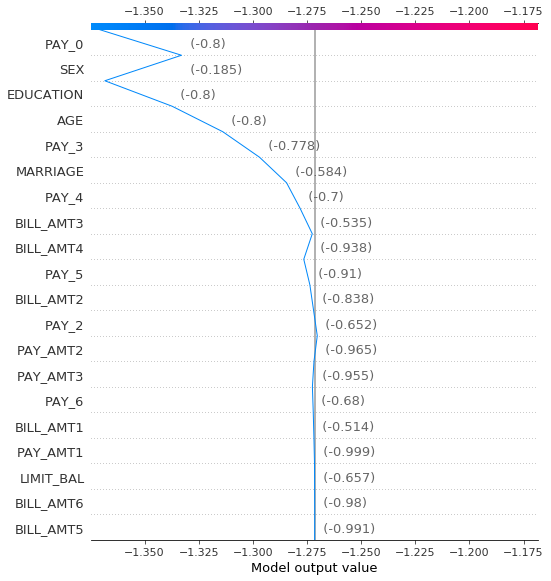

In [793]:
c = 0 
i = 2
shap.decision_plot( explainer_shap.expected_value[c],
                   shap_values[c],
                   test_value.detach().numpy(),
                   feature_names=test.columns.tolist()
                  )

In [794]:
trans_columns = ReusePipe.return_trans_info()["in_var"]
trans_columns
# ReusePipe.return_trans_info()

['LIMIT_BAL',
 'AGE',
 'PAY_0',
 'PAY_2',
 'PAY_3',
 'PAY_4',
 'PAY_5',
 'PAY_6',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6',
 'EDUCATION',
 'MARRIAGE',
 'SEX']

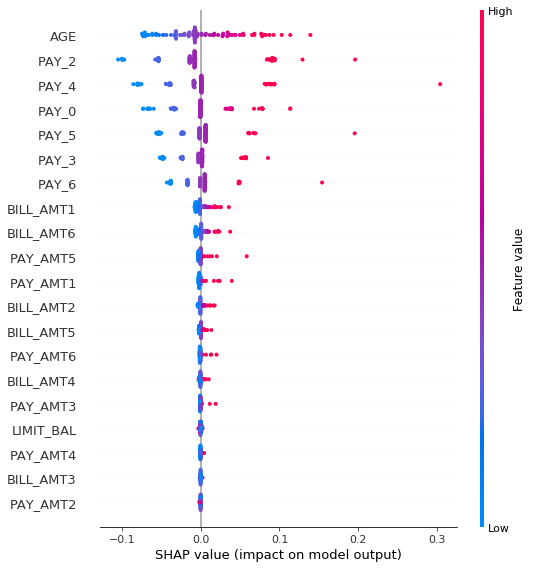

In [796]:
shap.summary_plot(shap_values, test_value, feature_names=trans_columns)

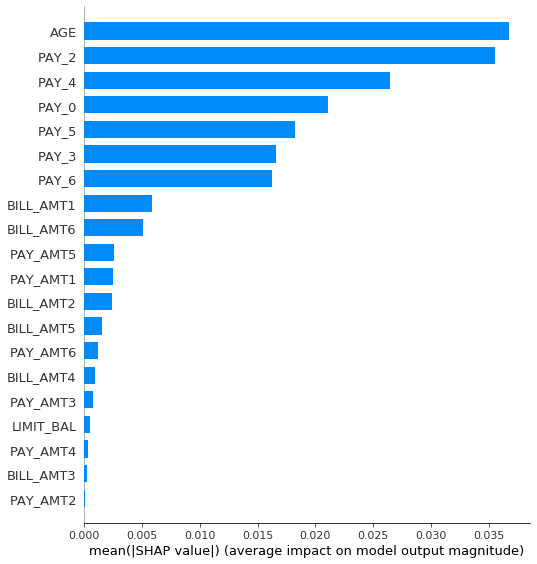

In [797]:
shap.summary_plot(shap_values, test_value, 
                  feature_names=trans_columns, plot_type='bar')

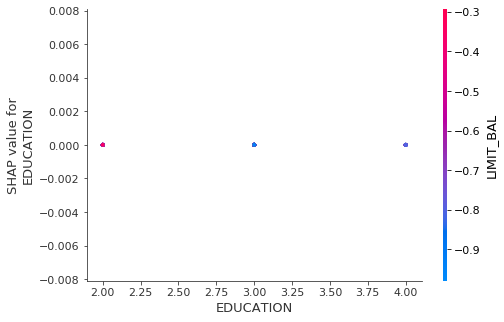

In [799]:
shap.dependence_plot(20 , shap_values, 
                     test_value.detach().numpy(), feature_names= trans_columns)